# init

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff
from pymfe.mfe import MFE
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import svm
import sklearn.metrics as skm
from sklearn import metrics
import pdb
import random
import xgboost as xgb
from catboost import Pool, CatBoostRegressor
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_ttest

stdTable = "./data/recommender/std-table.csv"
path_arff = "./data/datasets/arff/"
path_index = "./data/index/arff/"
# files_arff = os.listdir(path_arff)

path = "./data/experimento/datasets/selected/cleaned/"
tablePath = savePath = "./data/recommender/meta-features.csv"

ccTable = "./metafeatures/meta-table-CC.csv"
accTable = "./metafeatures/meta-table-ACC.csv"
smmTable = "./metafeatures/meta-table-SMM.csv"
hdyTable = "./metafeatures/meta-table-HDy.csv"
dysTable = "./metafeatures/meta-table-DyS.csv"
sordTable = "./metafeatures/meta-table-SORD.csv"
msTable = "./metafeatures/meta-table-MS.csv"
# ms2Table = "./metafeatures/meta-table-MS2.csv"
maxTable = "./metafeatures/meta-table-MAX.csv"
xTable = "./metafeatures/meta-table-X.csv"
t50Table = "./metafeatures/meta-table-T50.csv"

algList = ["CC","ACC","SMM","HDy","DyS","SORD","MS","MAX","X","T50"]
pathList = [ccTable, accTable, smmTable, hdyTable, dysTable, sordTable, msTable, maxTable, xTable, t50Table]

experiment_tables_path = './experiment_tables/'
experiment_tables_dict = None
processed_datasets_df = None

datasets_path = './datasets/'
files = os.listdir(datasets_path)

# preprocess

In [2]:
def load_experiment_tables():
    exp_tables_dict = {key: None for key in ['CC', 'ACC', 'PACC', 'PCC', 'SMM', 'HDy', 'DyS', 'SORD', 'MS', 'MS2', 'MAX', 'X']}
        
    for key in exp_tables_dict.keys():
        if os.path.isfile(experiment_tables_path + 'experiment_table_' + key + '.csv'):
            exp_tables_dict[key] = pd.read_csv(experiment_tables_path + 'experiment_table_' + key + '.csv')
        else:
            exp_tables_dict[key] = pd.DataFrame(columns=['dataset_name', 'alpha', 'sample_size', 'real_p', 'pred_p', 'abs_error', 'run_time'])
    
    return exp_tables_dict

experiment_tables_dict = load_experiment_tables()
df_dict = {key: None for key in list(experiment_tables_dict.keys())}


for key in experiment_tables_dict:
    df_dict[key] = experiment_tables_dict[key].groupby('dataset_name')['abs_error'].aggregate('mean')

meta_features_table = pd.read_csv('./metafeatures/meta-features-table.csv')

algList = []
tableList = []
for counter in df_dict.keys():
    algList.append(counter)

    y = df_dict[counter].values

    X = meta_features_table.values
    np.nan_to_num(X, copy=False)
    
    row, column = np.where(X > np.finfo(np.float32).max)
    for i in range(len(row)):
        X[row[i]][column[i]] = np.finfo(np.float32).max

    tableList.append((X, y))

processed_datasets_df = pd.read_csv('./experiment_tables/processed_datasets.csv')
datasets = processed_datasets_df['dataset'].tolist()

for key in df_dict.keys():
    df = pd.DataFrame({'MAE': df_dict[key].to_list(), 'Dataset': datasets})
    df.to_csv('./experiment_tables/new_experiment_tables/experiment_table_' + str(key) + '.csv', index = False)
processed_datasets_df = pd.read_csv('./experiment_tables/processed_datasets.csv')

# experiment

In [3]:
# rf_reg = RandomForestRegressor()
# xgb_reg = xgb.XGBRegressor()
# svr_reg = svm.SVR()

# instance_len = len(tableList[0][0])
# rf_results = {}
# xgb_results = {}
# svr_results = {}
# cat_results = {}

# j = 0
# for (X, y) in tableList:
#   rf_results_list = []
#   xgb_results_list = []
#   svr_results_list = []
#   cat_results_list = []
#   algName = algList[j]
#   j += 1


#   for i in range(0, len(X)):
#     X_train = np.delete(X, i, 0)
#     y_train = np.delete(y, i, 0)

#     X_test = X[i]
#     X_test = X_test.reshape(1, -1)
#     y_test = y[i]

#     rf_reg.fit(X_train, y_train)
#     xgb_reg.fit(X_train, y_train)
#     svr_reg.fit(X_train, y_train)
  
#     rf_abs_error = rf_reg.predict(X_test)
#     xgb_abs_error = xgb_reg.predict(X_test)
#     svr_abs_error = svr_reg.predict(X_test)


#     rf_results_list.append([y_test, rf_abs_error[0]])
#     xgb_results_list.append([y_test, xgb_abs_error[0]])
#     svr_results_list.append([y_test, svr_abs_error[0]])


#   rf_results[algName] = rf_results_list
#   xgb_results[algName] = xgb_results_list
#   svr_results[algName] = svr_results_list


# # # # RANDOM FORESTS
# # # #
# data = []
# cols = []
# for key in rf_results:
#   cols.append('abs-error-'+key)
#   cols.append('abs-error-'+key+'-predicted')
# cols.append('abs-error-ideal')
# cols.append('quantifier-ideal')
# cols.append('quantifier-ideal-num')
# cols.append('abs-error-recommended')
# cols.append('quantifier-recommended')
# cols.append('quantifier-recommended-num')
# i = 1
# for key in rf_results:
#     cols.append('rank-' + str(i))
#     i += 1


# i = 0
# for i in range(0, instance_len):
#   abs_error_ideal = 2
#   quantifier_ideal = 'NULL'
#   quantifier_ideal_num = -1
#   abs_error_recommended = 2
#   quantifier_recommended = 'NULL'
#   quantifier_recommended_num = -1
#   row = []
#   algNum = 0
#   rank = {}

#   for a in algList:
#     row.append(rf_results[a][i][0])
#     row.append(rf_results[a][i][1])

#     rank[algNum] = rf_results[a][i][1]

#     if rf_results[a][i][0] < abs_error_ideal:
#       abs_error_ideal = rf_results[a][i][0]
#       quantifier_ideal = a
#       quantifier_ideal_num = algNum

#     if rf_results[a][i][1] < abs_error_recommended:
#       abs_error_recommended = rf_results[a][i][1]
#       quantifier_recommended = a
#       quantifier_recommended_num = algNum

#     algNum += 1
#   rank = sorted(rank.items(), key=lambda item: item[1])

#   row.append(abs_error_ideal)
#   row.append(quantifier_ideal)
#   row.append(quantifier_ideal_num)
#   row.append(abs_error_recommended)
#   row.append(quantifier_recommended)
#   row.append(quantifier_recommended_num)
#   for key in rank:
#     row.append(int(key[0]))

#   data.append(row)

# rf_table = pd.DataFrame(data, columns = cols)



# # # # XGBOOST
# # # #
# data = []
# cols = []
# for key in xgb_results:
#   cols.append('abs-error-'+key)
#   cols.append('abs-error-'+key+'-predicted')
# cols.append('abs-error-ideal')
# cols.append('quantifier-ideal')
# cols.append('quantifier-ideal-num')
# cols.append('abs-error-recommended')
# cols.append('quantifier-recommended')
# cols.append('quantifier-recommended-num')
# i = 1
# for key in xgb_results:
#     cols.append('rank-' + str(i))
#     i += 1

# i = 0
# for i in range(0, instance_len):
#   abs_error_ideal = 2
#   quantifier_ideal = 'NULL'
#   quantifier_ideal_num = -1
#   abs_error_recommended = 2
#   quantifier_recommended = 'NULL'
#   quantifier_recommended_num = -1
#   row = []
#   algNum = 0
#   rank = {}

#   for a in algList:
#     row.append(xgb_results[a][i][0])
#     row.append(xgb_results[a][i][1])

#     rank[algNum] = xgb_results[a][i][1]

#     if xgb_results[a][i][0] < abs_error_ideal:
#       abs_error_ideal = xgb_results[a][i][0]
#       quantifier_ideal = a
#       quantifier_ideal_num = algNum

#     if xgb_results[a][i][1] < abs_error_recommended:
#       abs_error_recommended = xgb_results[a][i][1]
#       quantifier_recommended = a
#       quantifier_recommended_num = algNum

#     algNum += 1
#   rank = sorted(rank.items(), key=lambda item: item[1])

#   row.append(abs_error_ideal)
#   row.append(quantifier_ideal)
#   row.append(quantifier_ideal_num)
#   row.append(abs_error_recommended)
#   row.append(quantifier_recommended)
#   row.append(quantifier_recommended_num)
#   for key in rank:
#     row.append(int(key[0]))

#   data.append(row)
# xgb_table = pd.DataFrame(data, columns = cols)



# # # # SVM
# # # #
# data = []
# cols = []
# for key in svr_results:
#   cols.append('abs-error-'+key)
#   cols.append('abs-error-'+key+'-predicted')
# cols.append('abs-error-ideal')
# cols.append('quantifier-ideal')
# cols.append('quantifier-ideal-num')
# cols.append('abs-error-recommended')
# cols.append('quantifier-recommended')
# cols.append('quantifier-recommended-num')
# i = 1
# for key in svr_results:
#     cols.append('rank-' + str(i))
#     i += 1

# i = 0
# for i in range(0, instance_len):
#   abs_error_ideal = 2
#   quantifier_ideal = 'NULL'
#   quantifier_ideal_num = -1
#   abs_error_recommended = 2
#   quantifier_recommended = 'NULL'
#   quantifier_recommended_num = -1
#   row = []
#   algNum = 0
#   rank = {}

#   for a in algList:
#     row.append(svr_results[a][i][0])
#     row.append(svr_results[a][i][1])

#     rank[algNum] = svr_results[a][i][1]

#     if svr_results[a][i][0] < abs_error_ideal:
#       abs_error_ideal = svr_results[a][i][0]
#       quantifier_ideal = a
#       quantifier_ideal_num = algNum

#     if svr_results[a][i][1] < abs_error_recommended:
#       abs_error_recommended = svr_results[a][i][1]
#       quantifier_recommended = a
#       quantifier_recommended_num = algNum

#     algNum += 1
#   rank = sorted(rank.items(), key=lambda item: item[1])

#   row.append(abs_error_ideal)
#   row.append(quantifier_ideal)
#   row.append(quantifier_ideal_num)
#   row.append(abs_error_recommended)
#   row.append(quantifier_recommended)
#   row.append(quantifier_recommended_num)
#   for key in rank:
#     row.append(int(key[0]))

#   data.append(row)
# svr_table = pd.DataFrame(data, columns = cols)

# # # rf_table.to_csv("./recommendation/recommendation_table_rf.csv", index = False)
# # # xgb_table.to_csv("./recommendation/recommendation_table_xgb.csv", index = False)
# # # svr_table.to_csv("./recommendation/recommendation_table_svr.csv", index = False)

# analysis

In [4]:
# # rf_table.to_csv("./recommendation/recommendation_table_rf.csv", index = False)
# # xgb_table.to_csv("./recommendation/recommendation_table_xgb.csv", index = False)
# # svr_table.to_csv("./recommendation/recommendation_table_svr.csv", index = False)

rf_table = pd.read_csv("./recommendation/recommendation_table_rf.csv")
xgb_table = pd.read_csv("./recommendation/recommendation_table_xgb.csv")
svr_table = pd.read_csv("./recommendation/recommendation_table_svr.csv")
# cat_table = pd.read_csv("./recommendation/recommendation_table_cat.csv")

In [5]:
results_dataframe = pd.DataFrame(columns=['dataset', 'regressor', 'regressor'])

rf_algs = []
xgb_algs = []
svr_algs = []

for rank in rf_table['rank-1'].tolist():
    rf_algs.append(algList[rank])

for rank in xgb_table['rank-1'].tolist():
    xgb_algs.append(algList[rank])

for rank in svr_table['rank-1'].tolist():
    svr_algs.append(algList[rank])


# friedmann + holm

In [7]:
# algList.remove('T50')

test_dict = {}
optimal_dict = {}
for d in datasets:
    test_dict[d.split('.csv')[0]] = None
    optimal_dict[d.split('.csv')[0]] = None

for dataset in test_dict.keys():
    counter_error_dict = {key: [] for key in algList}

    for alg in algList:
        temp_df = experiment_tables_dict[alg].loc[experiment_tables_dict[alg]['dataset_name'] == dataset]
        temp_df = temp_df.groupby('alpha').mean(numeric_only = True)
        temp_df = temp_df.reset_index()
        counter_error_dict[alg] = temp_df['abs_error'].tolist()
    test_dict[dataset] = pd.DataFrame()
    for key in counter_error_dict.keys():
        test_dict[dataset][key] = counter_error_dict[key]

test_index = 0
for dataset in test_dict.keys():
    groups = []
    for counter in test_dict[dataset].columns.tolist():
        groups.append(test_dict[dataset][counter].tolist())
    res = friedmanchisquare(*groups)
    if res.pvalue < 0.05:
        # HOLM
        best = test_dict[dataset].mean().sort_values().index[0]
        best_index = test_dict[dataset].columns.tolist().index(best)
        opt_set = set()
        opt_set.add(best)

        res = posthoc_ttest(groups, p_adjust='holm')
        
        index = 0
        for element in res[best_index+1]:
            if element >= 0.05:
                opt_set.add(test_dict[dataset].columns.tolist()[index])
            index += 1
        
        optimal_dict[dataset] = opt_set
    else:
        optimal_dict[dataset] = set(algList)

# top 3 analysis

In [46]:
dt_list = []
for d in datasets:
    dt_list.append(d.split('.csv')[0])

rf_top_dict = {key: None for key in dt_list}
xgb_top_dict = {key: None for key in dt_list}
svr_top_dict = {key: None for key in dt_list}



top = 3



index = 0
for dataset in rf_top_dict.keys():
    quantifier_set = set()
    for i in range(0, top):
        quantifier_set.add(algList[rf_table.loc[index]['rank-'+str(i+1)]])
    rf_top_dict[dataset] = quantifier_set
    index += 1

index = 0
for dataset in xgb_top_dict.keys():
    quantifier_set = set()
    for i in range(0, top):
        quantifier_set.add(algList[xgb_table.loc[index]['rank-'+str(i+1)]])
    xgb_top_dict[dataset] = quantifier_set
    index += 1

index = 0
for dataset in svr_top_dict.keys():
    quantifier_set = set()
    for i in range(0, top):
        quantifier_set.add(algList[svr_table.loc[index]['rank-'+str(i+1)]])
    svr_top_dict[dataset] = quantifier_set
    index += 1



index = 0
for dataset in dt_list:
    if rf_top_dict[dataset] in optimal_dict[dataset]:
        rf_top_hit_list.append(1)
    else:
        rf_top_hit_list.append(0)
    index += 1


index = 0
for dataset in dt_list:
    if xgb_top_dict[dataset] in optimal_dict[dataset]:
        xgb_top_hit_list.append(1)
    else:
        xgb_top_hit_list.append(0)
    index += 1


index = 0
for dataset in dt_list:
    if svr_top_dict[dataset] in optimal_dict[dataset]:
        svr_top_hit_list.append(1)
    else:
        svr_top_hit_list.append(0)
    index += 1

hit_list = rf_hit_list + xgb_hit_list + svr_hit_list
datasets_list = dt_list + dt_list + dt_list
regressor_list = ['Random Forests'] * 133 + ['XGBOOST'] * 133 + ['SVM'] * 133
quantifier_recommended_list = rf_recommended_list + xgb_recommended_list + svr_recommended_list

recommender_hit_df = pd.DataFrame({'dataset': datasets_list, 'regressor': regressor_list, 'quantifier_recommended': quantifier_recommended_list, 'hit': hit_list})
recommender_hit_df.to_csv('./recommender_hit_table/recommender_hit_table.csv', index = False)
hit_rate_table = pd.DataFrame(columns=['Random Forest HitRate', 'XGBOOST HitRate', 'SVM HitRate'])
hit_rate_table.loc[len(hit_rate_table)] = [np.mean(rf_hit_list), np.mean(xgb_hit_list), np.mean(xgb_hit_list)]
hit_rate_table.to_csv('./recommender_hit_table/recommender_hit_rate_table.csv', index = False)

# Hit Rate

In [8]:
dt_list = []
for d in datasets:
    dt_list.append(d.split('.csv')[0])

rf_hit_list = []
xgb_hit_list = []
svr_hit_list = []

rf_recommended_list = rf_table['quantifier-recommended'].values.tolist()
index = 0
for dataset in dt_list:
    if rf_recommended_list[index] in optimal_dict[dataset]:
        rf_hit_list.append(1)
    else:
        rf_hit_list.append(0)
    index += 1

xgb_recommended_list = xgb_table['quantifier-recommended'].values.tolist()
index = 0
for dataset in dt_list:
    if xgb_recommended_list[index] in optimal_dict[dataset]:
        xgb_hit_list.append(1)
    else:
        xgb_hit_list.append(0)
    index += 1

svr_recommended_list = svr_table['quantifier-recommended'].values.tolist()
index = 0
for dataset in dt_list:
    if svr_recommended_list[index] in optimal_dict[dataset]:
        svr_hit_list.append(1)
    else:
        svr_hit_list.append(0)
    index += 1

hit_list = rf_hit_list + xgb_hit_list + svr_hit_list
datasets_list = dt_list + dt_list + dt_list
regressor_list = ['Random Forests'] * 133 + ['XGBOOST'] * 133 + ['SVM'] * 133
quantifier_recommended_list = rf_recommended_list + xgb_recommended_list + svr_recommended_list

recommender_hit_df = pd.DataFrame({'dataset': datasets_list, 'regressor': regressor_list, 'quantifier_recommended': quantifier_recommended_list, 'hit': hit_list})
recommender_hit_df.to_csv('./recommender_hit_table/recommender_hit_table.csv', index = False)
hit_rate_table = pd.DataFrame(columns=['Random Forest HitRate', 'XGBOOST HitRate', 'SVM HitRate'])
hit_rate_table.loc[len(hit_rate_table)] = [np.mean(rf_hit_list), np.mean(xgb_hit_list), np.mean(xgb_hit_list)]
hit_rate_table.to_csv('./recommender_hit_table/recommender_hit_rate_table.csv', index = False)

# plots

In [ ]:
processed_datasets_df = pd.read_csv('./experiment_tables/processed_datasets.csv')
datasets = processed_datasets_df['dataset'].tolist()

In [ ]:
rf_table

In [ ]:
rows = rf_table['abs-error-DyS'].to_list()
dys = []
i = 0
for r in rows:
    dys.append(rf_table.loc[i]['abs-error-DyS'])
    i += 1


rows = rf_table['quantifier-recommended'].to_list()
rec = []
i = 0
for r in rows:
    rec.append(rf_table.loc[i]['abs-error-' + r])
    i += 1

rows = rf_table['quantifier-ideal'].to_list()
rec2 = []
i = 0
for r in rows:
    rec2.append(rf_table.loc[i]['abs-error-' + r])
    i += 1

rows = rf_table['quantifier-ideal'].to_list()
rec3 = []
i = 0
for r in rows:
    rec3.append(rf_table.loc[i]['abs-error-' + random.choice(algList)])
    i += 1

ranking_dict = {'rank-1': [], 'rank-2': [], 'rank-3': [], 'rank-4': [], 'rank-5': [], 'rank-6': [], 'rank-7': [], 'rank-8': [], 'rank-9': [], 'rank-10': [], 'rank-11': [], 'rank-12': [], 'rank-13': []}
rows = rf_table['quantifier-ideal'].to_list()
i = 0
for r in rows:
    for j in range(13):
        ranking_dict['rank-'+str(j+1)].append(algList[rf_table.loc[i]['rank-'+str(j+1)]])
    i += 1

def generate_ensemble_results_rf(top, type):
    rec = []
    i = 0
    for r in rows:
        j = 0
        error_list = []
        for j in range(top):
            error_list.append(rf_table.loc[i][ 'abs-error-' + ranking_dict['rank-'+str(j+1)][i] ])
        if type == 'mean':
            rec.append(np.mean(error_list))
        elif type == 'median':
            rec.append(np.median(error_list))
        i += 1
    return rec


import matplotlib.pyplot as plt
import numpy as np

top = 5
rec4 = generate_ensemble_results_rf(top, 'median')
rec5 = generate_ensemble_results_rf(top, 'mean')

data = [rec2, rec3, dys, rec, rec4, rec5]
fig = plt.figure(figsize =(15, 7))

# Creating plot
plt.boxplot(data)
plt.xticks([1,2,3,4,5,6], ['Ideal', 'Aleatória', 'DyS', 'Recomendador', 'Ensemble - Median (Top '+ str(top) +')', 'Ensemble - Mean (Top '+ str(top) +')'])
# plt.title('Distribuição de erros médios absolutos (MAE) por método de escolha de quantificador')
plt.xlabel('Método de escolha do quantificador (RANDOM FOREST REGRESSOR)')
plt.ylabel('MAE')
# show plot
plt.show()

# error_topline = pd.DataFrame({'MAE': rec2, 'Dataset': datasets})
# error_topline.to_csv('./recommendation/error_topline.csv', index = False)
# error_baseline = pd.DataFrame({'MAE': rec3, 'Dataset': datasets})
# error_baseline.to_csv('./recommendation/error_baseline.csv', index = False)
# error_dys = pd.DataFrame({'MAE': dys, 'Dataset': datasets})
# error_dys.to_csv('./recommendation/error_dys.csv', index = False)

# error_recommender_rf = pd.DataFrame({'MAE': rec, 'Dataset': datasets})
# error_recommender_rf.to_csv('./recommendation/error_recommender_rf.csv', index = False)
error_ensemble_median_rf = pd.DataFrame({'MAE': rec4, 'Dataset': datasets})
error_ensemble_median_rf.to_csv('./recommendation/error_ensemble_median_top5_rf.csv', index = False)
error_ensemble_mean_rf = pd.DataFrame({'MAE': rec5, 'Dataset': datasets})
error_ensemble_mean_rf.to_csv('./recommendation/error_ensemble_mean_top5_rf.csv', index = False)

# better plot

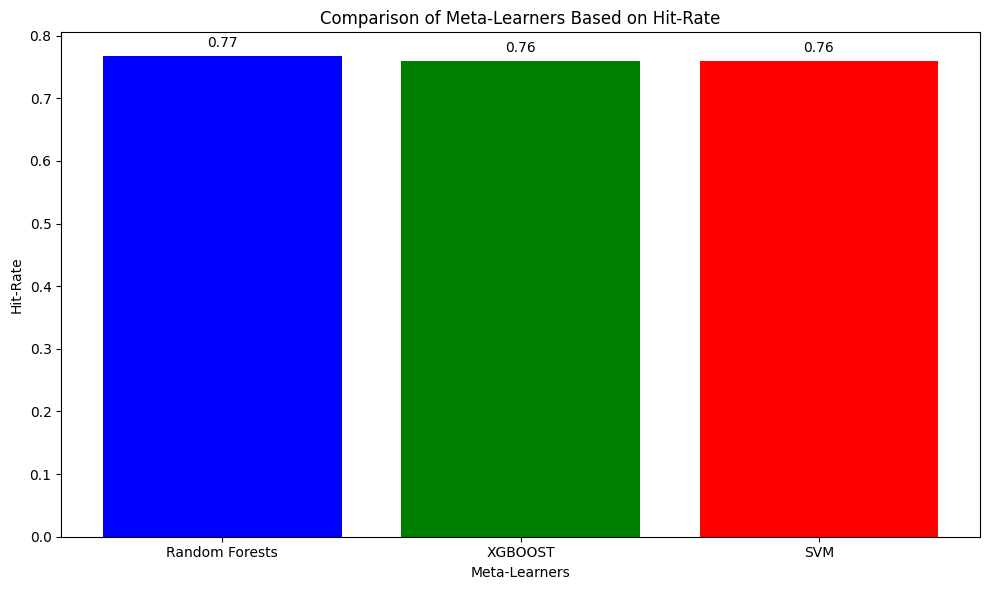

In [12]:
import matplotlib.pyplot as plt
import numpy as np

hit_rate_table = pd.read_csv('./recommender_hit_table/recommender_hit_rate_table.csv')

# Hit-rate data for each meta-learner
meta_learners = ['Random Forests', 'XGBOOST', 'SVM']
hit_rates = hit_rate_table.loc[0].values.tolist()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar plot
bars = plt.bar(meta_learners, hit_rates, color=['b', 'g', 'r', 'c', 'm'])

# Adding labels and title
plt.xlabel('Meta-Learners')
plt.ylabel('Hit-Rate')
plt.title('Comparison of Meta-Learners Based on Hit-Rate')

# Adding the hit-rate values on top of the bars
for bar, hit_rate in zip(bars, hit_rates):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(hit_rate, 2), ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# ranking_dict = {'rank-1': [], 'rank-2': [], 'rank-3': [], 'rank-4': [], 'rank-5': [], 'rank-6': [], 'rank-7': [], 'rank-8': [], 'rank-9': [], 'rank-10': [], 'rank-11': [], 'rank-12': [], 'rank-13': []}
# rows = rf_table['quantifier-ideal'].to_list()
# i = 0
# for r in rows:
#     for j in range(13):
#         ranking_dict['rank-'+str(j+1)].append(algList[rf_table.loc[i]['rank-'+str(j+1)]])
#     i += 1



# for r in rows:


In [ ]:
# rows = xgb_table['abs-error-DyS'].to_list()
# dys = []
# i = 0
# for r in rows:
#     dys.append(xgb_table.loc[i]['abs-error-DyS'])
#     i += 1


rows = xgb_table['quantifier-recommended'].to_list()
rec = []
i = 0
for r in rows:
    rec.append(xgb_table.loc[i]['abs-error-' + r])
    i += 1

# rows = xgb_table['quantifier-ideal'].to_list()
# rec2 = []
# i = 0
# for r in rows:
#     rec2.append(xgb_table.loc[i]['abs-error-' + r])
#     i += 1

# rows = xgb_table['quantifier-ideal'].to_list()
# rec3 = []
# i = 0
# for r in rows:
#     rec3.append(xgb_table.loc[i]['abs-error-' + random.choice(algList)])
#     i += 1

ranking_dict = {'rank-1': [], 'rank-2': [], 'rank-3': [], 'rank-4': [], 'rank-5': [], 'rank-6': [], 'rank-7': [], 'rank-8': [], 'rank-9': [], 'rank-10': [], 'rank-11': [], 'rank-12': [], 'rank-13': []}
rows = xgb_table['quantifier-ideal'].to_list()
i = 0
for r in rows:
    for j in range(13):
        ranking_dict['rank-'+str(j+1)].append(algList[xgb_table.loc[i]['rank-'+str(j+1)]])
    i += 1

def generate_ensemble_results_xgb(top, type):
    rec = []
    i = 0
    for r in rows:
        j = 0
        error_list = []
        for j in range(top):
            error_list.append(xgb_table.loc[i][ 'abs-error-' + ranking_dict['rank-'+str(j+1)][i] ])
        if type == 'mean':
            rec.append(np.mean(error_list))
        elif type == 'median':
            rec.append(np.median(error_list))
        i += 1
    return rec


import matplotlib.pyplot as plt
import numpy as np

top = 5
rec4 = generate_ensemble_results_xgb(top, 'median')
rec5 = generate_ensemble_results_xgb(top, 'mean')

data = [rec2, rec3, dys, rec, rec4, rec5]
fig = plt.figure(figsize =(15, 7))

# Creating plot
plt.boxplot(data)
plt.xticks([1,2,3,4,5,6], ['Ideal', 'Aleatória', 'DyS', 'Recomendador', 'Ensemble - Median (Top '+ str(top) +')', 'Ensemble - Mean (Top '+ str(top) +')'])
# plt.title('Distribuição de erros médios absolutos (MAE) por método de escolha de quantificador')
plt.xlabel('Método de escolha do quantificador (XGBOOST)')
plt.ylabel('MAE')
# show plot
plt.show()

# error_recommender_xgb = pd.DataFrame({'MAE': rec, 'Dataset': datasets})
# error_recommender_xgb.to_csv('./recommendation/error_recommender_xgb.csv', index = False)
error_ensemble_median_xgb = pd.DataFrame({'MAE': rec4, 'Dataset': datasets})
error_ensemble_median_xgb.to_csv('./recommendation/error_ensemble_median_top5_xgb.csv', index = False)
error_ensemble_mean_xgb = pd.DataFrame({'MAE': rec5, 'Dataset': datasets})
error_ensemble_mean_xgb.to_csv('./recommendation/error_ensemble_mean_top5_xgb.csv', index = False)

In [ ]:
# rows = svr_table['abs-error-DyS'].to_list()
# dys = []
# i = 0
# for r in rows:
#     dys.append(svr_table.loc[i]['abs-error-DyS'])
#     i += 1


rows = svr_table['quantifier-recommended'].to_list()
rec = []
i = 0
for r in rows:
    rec.append(svr_table.loc[i]['abs-error-' + r])
    i += 1

# rows = svr_table['quantifier-ideal'].to_list()
# rec2 = []
# i = 0
# for r in rows:
#     rec2.append(svr_table.loc[i]['abs-error-' + r])
#     i += 1

# rows = svr_table['quantifier-ideal'].to_list()
# rec3 = []
# i = 0
# for r in rows:
#     rec3.append(svr_table.loc[i]['abs-error-' + random.choice(algList)])
#     i += 1

ranking_dict = {'rank-1': [], 'rank-2': [], 'rank-3': [], 'rank-4': [], 'rank-5': [], 'rank-6': [], 'rank-7': [], 'rank-8': [], 'rank-9': [], 'rank-10': [], 'rank-11': [], 'rank-12': [], 'rank-13': []}
rows = svr_table['quantifier-ideal'].to_list()
i = 0
for r in rows:
    for j in range(13):
        ranking_dict['rank-'+str(j+1)].append(algList[svr_table.loc[i]['rank-'+str(j+1)]])
    i += 1

def generate_ensemble_results_svr(top, type):
    rec = []
    i = 0
    for r in rows:
        j = 0
        error_list = []
        for j in range(top):
            error_list.append(svr_table.loc[i][ 'abs-error-' + ranking_dict['rank-'+str(j+1)][i] ])
        if type == 'mean':
            rec.append(np.mean(error_list))
        elif type == 'median':
            rec.append(np.median(error_list))
        i += 1
    return rec


import matplotlib.pyplot as plt
import numpy as np

top = 5
rec4 = generate_ensemble_results_svr(top, 'median')
rec5 = generate_ensemble_results_svr(top, 'mean')
data = [rec2, rec3, dys, rec, rec4, rec5]

fig = plt.figure(figsize =(15, 7))
# Creating plot
plt.boxplot(data)
plt.xticks([1,2,3,4,5,6], ['Ideal', 'Aleatória', 'DyS', 'Recomendador', 'Ensemble - Median (Top '+ str(top) +')', 'Ensemble - Mean (Top '+ str(top) +')'])
# plt.title('Distribuição de erros médios absolutos (MAE) por método de escolha de quantificador')
plt.xlabel('Método de escolha do quantificador (SUPPORT VECTOR MACHINES)')
plt.ylabel('MAE')
# show plot
plt.show()


# error_recommender_svm = pd.DataFrame({'MAE': rec, 'Dataset': datasets})
# error_recommender_svm.to_csv('./recommendation/error_recommender_svm.csv', index = False)
error_ensemble_median_svm = pd.DataFrame({'MAE': rec4, 'Dataset': datasets})
error_ensemble_median_svm.to_csv('./recommendation/error_ensemble_median_top5_svm.csv', index = False)
error_ensemble_mean_svm = pd.DataFrame({'MAE': rec5, 'Dataset': datasets})
error_ensemble_mean_svm.to_csv('./recommendation/error_ensemble_mean_top5_svm.csv', index = False)

In [ ]:
rows = cat_table['quantifier-recommended'].to_list()
rec = []
i = 0
for r in rows:
    rec.append(cat_table.loc[i]['abs-error-' + r])
    i += 1

ranking_dict = {'rank-1': [], 'rank-2': [], 'rank-3': [], 'rank-4': [], 'rank-5': [], 'rank-6': [], 'rank-7': [], 'rank-8': [], 'rank-9': [], 'rank-10': [], 'rank-11': [], 'rank-12': [], 'rank-13': []}
rows = cat_table['quantifier-ideal'].to_list()
i = 0
for r in rows:
    for j in range(13):
        ranking_dict['rank-'+str(j+1)].append(algList[cat_table.loc[i]['rank-'+str(j+1)]])
    i += 1

def generate_ensemble_results_cat(top, type):
    rec = []
    i = 0
    for r in rows:
        j = 0
        error_list = []
        for j in range(top):
            error_list.append(cat_table.loc[i][ 'abs-error-' + ranking_dict['rank-'+str(j+1)][i] ])
        if type == 'mean':
            rec.append(np.mean(error_list))
        elif type == 'median':
            rec.append(np.median(error_list))
        i += 1
    return rec


import matplotlib.pyplot as plt
import numpy as np

top = 3
rec4 = generate_ensemble_results_cat(top, 'median')
rec5 = generate_ensemble_results_cat(top, 'mean')
data = [rec2, rec3, dys, rec, rec4, rec5]

fig = plt.figure(figsize =(15, 7))
# Creating plot
plt.boxplot(data)
plt.xticks([1,2,3,4,5,6], ['Ideal', 'Aleatória', 'DyS', 'Recomendador', 'Ensemble - Median (Top '+ str(top) +')', 'Ensemble - Mean (Top '+ str(top) +')'])
# plt.title('Distribuição de erros médios absolutos (MAE) por método de escolha de quantificador')
plt.xlabel('Método de escolha do quantificador (SUPPORT VECTOR MACHINES)')
plt.ylabel('MAE')
# show plot
plt.show()


error_recommender_cat = pd.DataFrame({'MAE': rec, 'Dataset': datasets})
error_recommender_cat.to_csv('./recommendation/error_recommender_cat.csv', index = False)
error_ensemble_median_cat = pd.DataFrame({'MAE': rec4, 'Dataset': datasets})
error_ensemble_median_cat.to_csv('./recommendation/error_ensemble_median_top3_cat.csv', index = False)
error_ensemble_mean_cat = pd.DataFrame({'MAE': rec5, 'Dataset': datasets})
error_ensemble_mean_cat.to_csv('./recommendation/error_ensemble_mean_top3_cat.csv', index = False)

In [ ]:
# x_axis = [] 
# y_axis = []
# top = len(pathList)

# for j in range(1, top+1):
#   ideal = table['quantifier-ideal-num'].values
#   pred = []
#   i = 1
#   for i in range(1, j+1):
#     pred.append(table['rank-'+str(i)].values.tolist())
#   pred = np.array(pred).T.tolist()
#   mat = []

#   i = 0
#   for row in pred:
#     correct = False
#     for element in row:
#       if ideal[i] == element:
#         correct = True
#         break
#     mat.append(correct)
#     i += 1

#   x_axis.append(np.count_nonzero(mat) / len(mat))
#   y_axis.append(j)

# plt.ylabel('Acurácia')
# plt.xlabel('Top N')
# plt.xticks([1,2,3,4,5,6,7,8,9,10])

# plt.plot(y_axis, x_axis)

In [ ]:
# print(x_axis)

In [ ]:
# top = 1

# x_axis = [0] * len(pathList)
# y_axis = algList

# for i in range(0, top):
#     rank = table.value_counts('rank-' + str(i+1))
#     for a in rank.index:
#         x_axis[a] += rank[a]

# x_axis = np.array(x_axis) / len(table)

# fig, ax = plt.subplots()
# ax.bar(y_axis, x_axis, width=1, edgecolor="white", linewidth=0.7)
# ax.set(xlim=(0, 9))
# plt.show()

In [ ]:
# top = 3
# auc_max = 1

# table_copy = table.copy(deep=True)
# auc = pd.read_csv("./auc/auc_score.csv")
# auc = auc['auc_score'].values.tolist()

# for i in range(0, len(auc)):
#     if auc[i] >= auc_max:
#         table_copy.drop(i, inplace = True)
# table_copy.reset_index(drop=True, inplace=True)

# x_axis = [0] * len(pathList)
# y_axis = algList

# for i in range(0, top):
#     rank = table_copy.value_counts('rank-' + str(i+1))
#     for a in rank.index:
#         x_axis[a] += rank[a]

# fig, ax = plt.subplots()
# ax.bar(y_axis, x_axis, width=1, edgecolor="white", linewidth=0.7)
# ax.set(xlim=(0, 9))
# plt.show()

# print(len(table_copy))

In [ ]:
# x_axis = [0] * len(pathList)
# y_axis = algList
# qnt = table['quantifier-ideal-num'].values

# for a in qnt:
#     x_axis[a] += 1

# fig, ax = plt.subplots()
# ax.bar(y_axis, x_axis, width=1, edgecolor="white", linewidth=0.7)
# ax.set(xlim=(0, 9))
# plt.show()

In [ ]:
# top = 1
# auc_max = 1

# table_copy = table.copy(deep=True)
# auc = pd.read_csv("./auc/auc_score.csv")
# auc = auc['auc_score'].values.tolist()

# for i in range(0, len(auc)):
#     if auc[i] >= auc_max:
#         table_copy.drop(i, inplace = True)
# table_copy.reset_index(drop=True, inplace=True)

# x_axis = [0] * 3
# y_axis = ['CC', 'MM', 'Adjusted']

# for i in range(0, top):
#     rank = table_copy.value_counts('rank-' + str(i+1))
#     for a in rank.index:
#         if a == 0:
#             x_axis[0] += rank[a]
#         elif a == 2 or a == 3 or a == 4 or a == 5:
#             x_axis[1] += rank[a]
#         else:
#             x_axis[2] += rank[a]

# fig, ax = plt.subplots()
# ax.bar(y_axis, x_axis, width=1, edgecolor="white", linewidth=0.7)
# ax.set(xlim=(0, 9))
# plt.show()

# print(len(table_copy))

In [ ]:
# x_axis = [0] * 3
# y_axis = ['CC', 'MM', 'Adjusted']
# qnt = table['quantifier-ideal-num'].values

# for a in qnt:
#     if a == 0:
#         x_axis[0] += 1
#     elif a == 2 or a == 3 or a == 4 or a == 5:
#         x_axis[1] += 1
#     else:
#         x_axis[2] += 1

# fig, ax = plt.subplots()
# ax.bar(y_axis, x_axis, width=1, edgecolor="white", linewidth=0.7)
# ax.set(xlim=(0, 9))
# plt.show()

In [ ]:
# i = 0
# dataframe = None
# X = None
# y = None
# X_list = []
# y_list = []

# for f in files:
#   if i == 14 or i == 16 or i == 21 or i == 25 or i == 33 or i == 68 or i == 69 or i == 70 or i == 71 or i == 72 or i == 73 or i == 74 or i == 75 or i == 76 or i == 82 or i == 88 or i == 98 or i == 104 or i == 109 or i == 115 or i == 118 or i == 119 or i == 120 or i == 128 or i == 129 or i == 130 or i == 132 or i == 139:
#     i += 1
#     continue
  
#   df = pd.read_csv(datasets_path + f)
#   df = df.dropna()

#   y = df.pop(df.columns[-1])
#   X = df

#   y_list.append(y.to_numpy())
#   X_list.append(X.to_numpy())

#   i += 1
# i = 0

# auc_list = []
# clf = RandomForestClassifier(n_estimators=500, random_state=42)
# for i in range(0, len(X_list)):
#   X = X_list[i]
#   y = y_list[i]

#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#   try:
#     clf.fit(X_train, y_train)

#     y_prediction_proba = clf.predict_proba(X_test)[:, 1]

#     # print(metrics.roc_auc_score(y_test, y_prediction_proba))

#     auc_list.append(metrics.roc_auc_score(y_test, y_prediction_proba))
#   except Exception as e:
#     print('Skipping ' + str(i) + '...\t\t\t' + str(e) + '\n')
# # auc_list
# auc = pd.DataFrame(data={'auc_score': auc_list})
# auc.to_csv('./auc/auc_score.csv', index=False)

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# paux = table['quantifier-recommended-num'].T
# taux = table['quantifier-ideal-num'].T
# paux = paux.values
# taux = taux.values

# predicted = []
# true = []

# for i in range(0, len(paux)):
#   predicted.append(int(paux[i]))
#   true.append(int(taux[i]))

# cm = confusion_matrix(true, predicted)
# cm

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=algList)

# disp.plot()

# plt.show()